## CREDIT CARD FRAUD

## DATASET - Normalized

Firstly we need to import the necessary libraries and configure the Spark session. After that, we load our data set, in order to analyse it, and perform EDA.

In [1]:
#Import libraries and configure spark session
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
from scipy import stats
from scipy.stats import norm
import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.feature import StringIndexer, VectorIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
# df1_new dataset to be used
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

import pyspark.sql.functions as f
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("xpto") \
    .getOrCreate()
sc = spark.sparkContext

In [2]:
# Load file
dfunbalance = spark.read.csv('dfscaled.csv', header=True, inferSchema=True, sep=",")

# Print Schema
dfunbalance.printSchema()

root
 |-- Class: integer (nullable = true)
 |-- Time_Scaled: double (nullable = true)
 |-- V1_Scaled: double (nullable = true)
 |-- V2_Scaled: double (nullable = true)
 |-- V3_Scaled: double (nullable = true)
 |-- V4_Scaled: double (nullable = true)
 |-- V5_Scaled: double (nullable = true)
 |-- V6_Scaled: double (nullable = true)
 |-- V7_Scaled: double (nullable = true)
 |-- V8_Scaled: double (nullable = true)
 |-- V9_Scaled: double (nullable = true)
 |-- V10_Scaled: double (nullable = true)
 |-- V11_Scaled: double (nullable = true)
 |-- V12_Scaled: double (nullable = true)
 |-- V13_Scaled: double (nullable = true)
 |-- V14_Scaled: double (nullable = true)
 |-- V15_Scaled: double (nullable = true)
 |-- V16_Scaled: double (nullable = true)
 |-- V17_Scaled: double (nullable = true)
 |-- V18_Scaled: double (nullable = true)
 |-- V19_Scaled: double (nullable = true)
 |-- V20_Scaled: double (nullable = true)
 |-- V21_Scaled: double (nullable = true)
 |-- V22_Scaled: double (nullable = true)

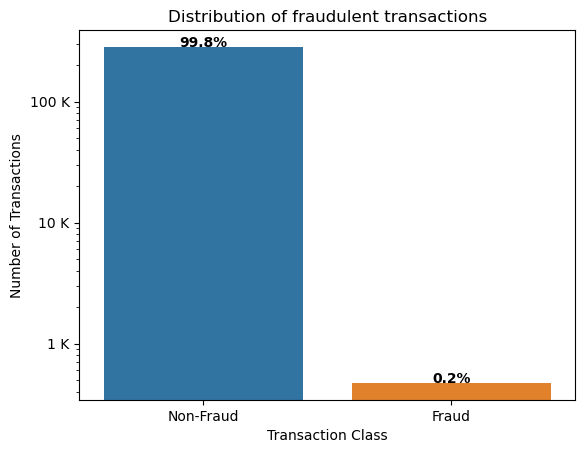

In [3]:
fraud_df = dfunbalance.select("Class").toPandas()

# Count the number of transactions for each class (fraudulent or not)
fraud_counts = fraud_df['Class'].value_counts()

# Calculate the percentage of each class
fraud_perc = fraud_counts / fraud_counts.sum() * 100

# Create a bar plot with logarithmic y-axis
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.yscale('log')

# Add percentage labels to the bars
for i, v in enumerate(fraud_counts):
    plt.text(i, v, f"{fraud_perc[i]:.1f}%", ha='center', fontweight='bold')

# Set the y-axis labels and formatter
plt.ylabel('Number of Transactions')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f} K'.format(x/1000)))

# Set the axis labels and title
plt.xlabel('Transaction Class')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.title('Distribution of fraudulent transactions')

plt.show()

## Features Selection - Using Imbalance Dataset

## Correlation Coefficient Method

Correlation is a measure of the linear relationship between 2 or more variables. Through correlation, we can predict one variable from the other. The logic behind using correlation for feature selection is that good variables correlate highly with the target. Furthermore, variables should be correlated with the target but uncorrelated among themselves.

If two variables are correlated, we can predict one from the other. Therefore, if two features are correlated, the model only needs one, as the second does not add additional information. We will use the Pearson Correlation here.

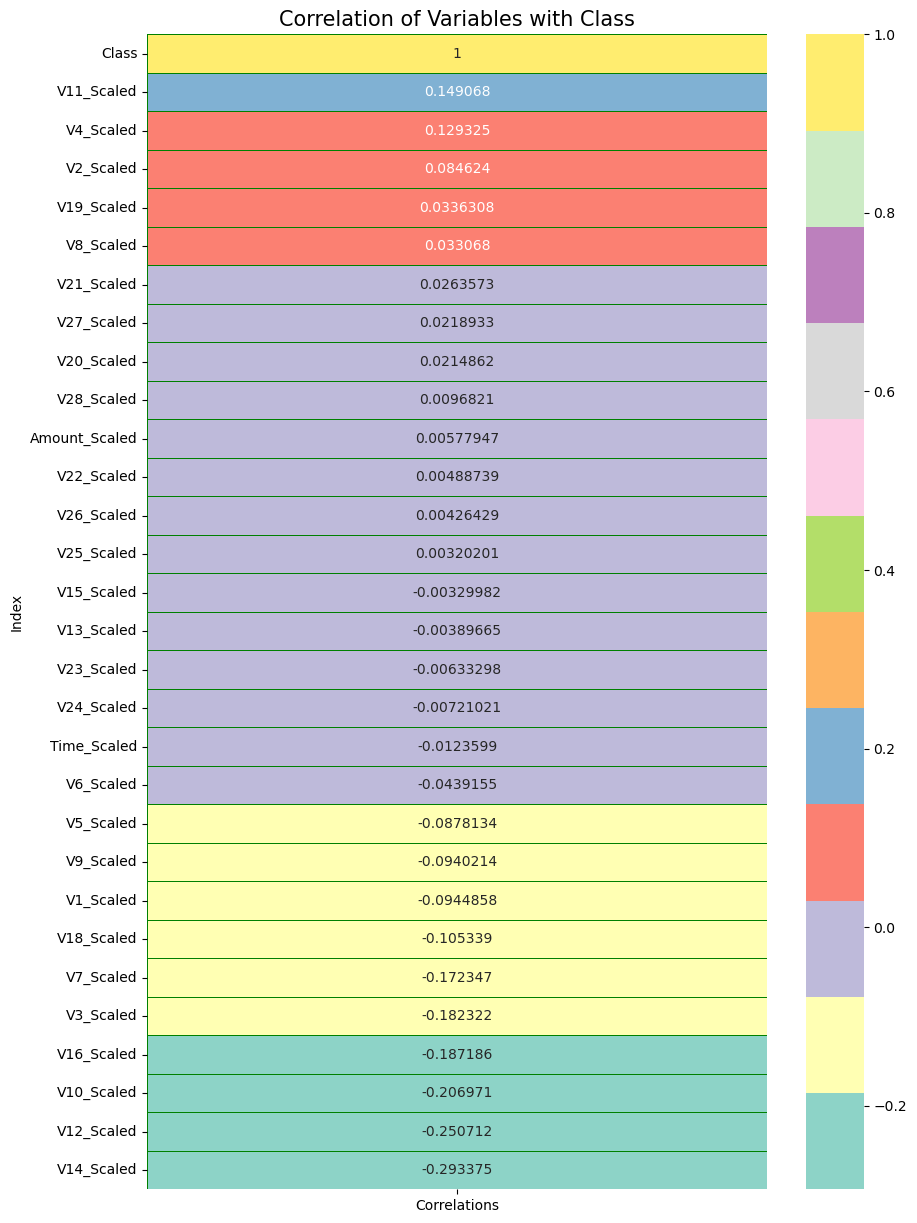

In [4]:
dfunbalance2 = dfunbalance.toPandas()

#df_balance =df_balance.drop(['Time_Scaled'],axis = 1)

corr = dfunbalance2.corrwith(dfunbalance2['Class'],method='pearson').reset_index()

corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False).head(30)

plt.figure(figsize=(10, 15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='Set3', linewidths=0.4, linecolor='green')

plt.title("Correlation of Variables with Class", fontsize=15)
plt.show()

##  Kbest Select with F_Classif Method

Select features according to the k highest scores.

In [5]:
X = dfunbalance2.drop(['Class'],axis = 1)
Y = dfunbalance2['Class'] # target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2, random_state = 42)

In [6]:
from sklearn.feature_selection import SelectKBest, f_classif
bestfeatures = SelectKBest(score_func=f_classif, k=29)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns) 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(6,'Score'))  


       Feature         Score
17  V17_Scaled  30923.940942
14  V14_Scaled  26719.472682
12  V12_Scaled  19029.988289
10  V10_Scaled  12697.821929
16  V16_Scaled  10302.273206
3    V3_Scaled   9755.632245


<BarContainer object of 30 artists>

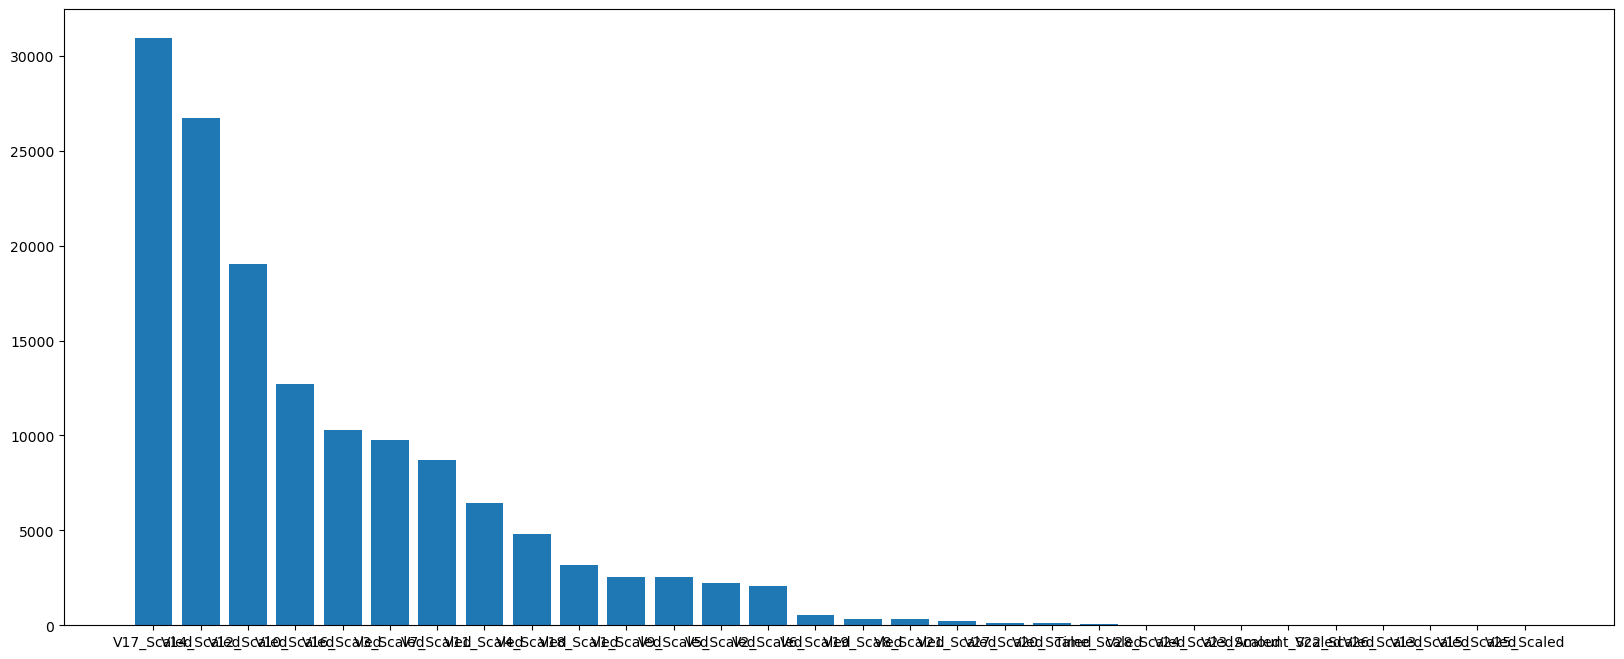

In [7]:
plt.figure(figsize=(20,8))
featureScores2 = featureScores.sort_values('Score', ascending=False)
plt.bar("Feature", "Score", data=featureScores2)


## KBest with Mutual Information Classification Method

Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [8]:
from sklearn.feature_selection import SelectKBest,mutual_info_classif
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=29)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns) 
feature_score3 = pd.concat([dfcolumns,dfscores],axis=1)
feature_score3.columns = ['Feature','Score'] 
print(feature_score3.nlargest(6,'Score'))  


       Feature     Score
17  V17_Scaled  0.007885
14  V14_Scaled  0.007805
12  V12_Scaled  0.007254
10  V10_Scaled  0.007161
11  V11_Scaled  0.006457
16  V16_Scaled  0.005736


<BarContainer object of 30 artists>

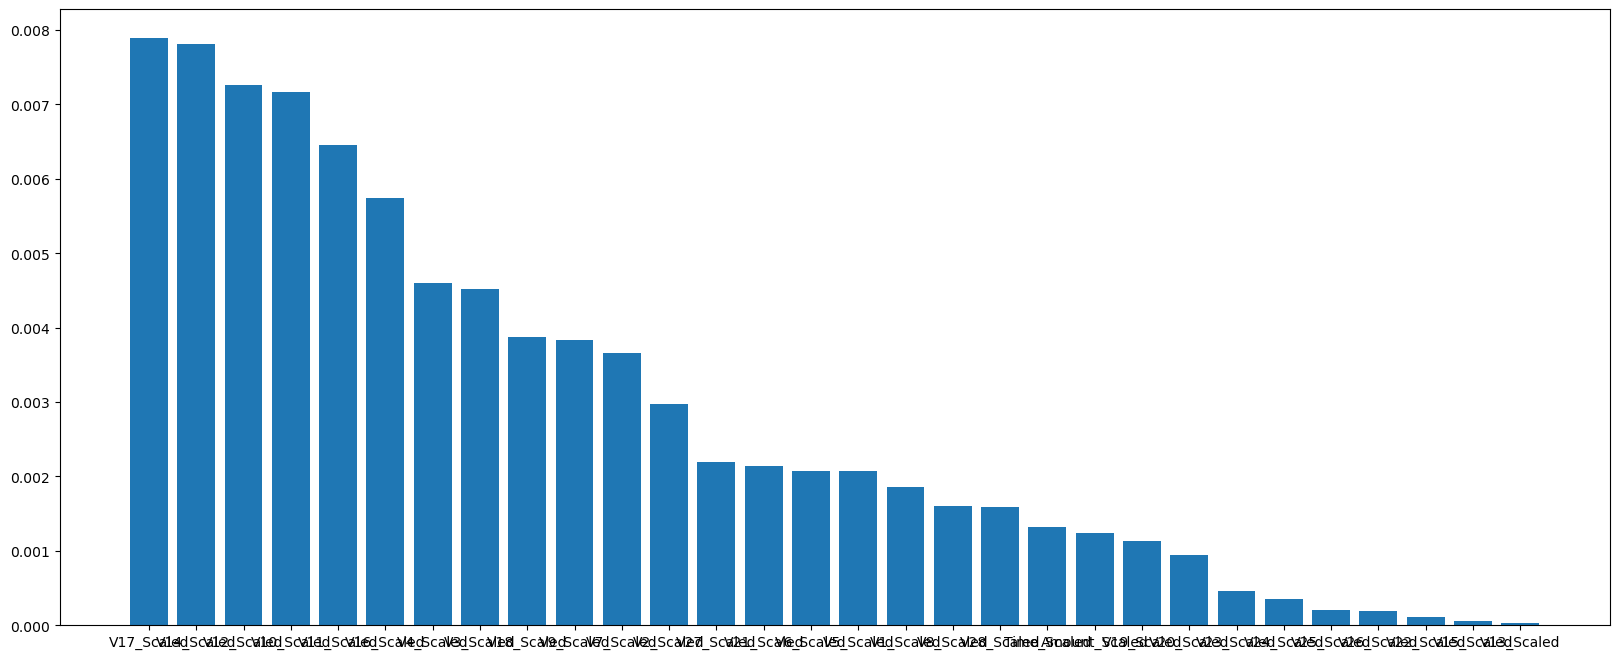

In [9]:
plt.figure(figsize=(20,8))
feature_score3 = feature_score3.sort_values('Score', ascending=False)
plt.bar("Feature", "Score", data=feature_score3)


## Observations:

Based on our analysis, we can conclude that features V16,  V12, V10, V14 and V17 have a higher potential to explain whether a fraud may occur or not. These variables could play a crucial role in identifying potential fraud and help prevent it. However, features V16 and V3 and V11 ans V16 have also potential according Kbest Select with F_Classif and KBest with Mutual Information Classification Methods, respectively. 
_______________________________________________________________________________________

## FEATURES SELECTION - Feature Importance Score

Feature Importance score here means any score generated from the trained model representing the weight or relevancy of the features to the prediction of the target feature.

The common theme of the problems is that when the dimensionality increases, the volume of the space increases so fast that the available data become sparse. This sparsity is problematic for any method that requires statistical significance.

In order to obtain a statistically sound and reliable result, the amount of data needed to support the result often grows exponentially with the dimensionality.

Also, organizing and searching data often relies on detecting areas where objects form groups with similar properties; in high dimensional data, however, all objects appear to be sparse and dissimilar in many ways, which prevents common data organization strategies from being efficient.

Several models are used for feature selection:Correlation or chi-square, Stepwise method, Lasso - Penalized likelihood,PCA and Input Perturbation.

Input Perturbation algorithm was introduced by Breiman in his seminal paper on random forests. Although he presented this algorithm in conjunction with random forests, it is model-independent and appropriate for any supervised learning model.


### Benefits of performing feature selection
Reduce Overfitting: Less redundant data means less opportunity to make decision based on irrelevant data(noise).
Improves Model Performance: Less misleading data means our model’s performance is improves.
Reduce Training Time: Less data means algorithm train faster.

## Train and test data split df

In [10]:
from pyspark.sql.functions import lit
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorSlicer

### Stratified split
Here I used stratified split instead of random split which can overcome the imblance data problem.

In [11]:
fractions =dfunbalance.select("Class").distinct().withColumn("fraction", lit(0.8)).rdd.collectAsMap()
df_train = dfunbalance.sampleBy('Class',fractions,seed=42)
df_test = dfunbalance.subtract(df_train)

In [12]:
df_train.head()

Row(Class=0, Time_Scaled=-1.996, V1_Scaled=-0.275, V2_Scaled=0.533, V3_Scaled=0.892, V4_Scaled=0.105, V5_Scaled=0.299, V6_Scaled=0.076, V7_Scaled=0.578, V8_Scaled=0.15, V9_Scaled=-0.26, V10_Scaled=-0.449, V11_Scaled=0.856, V12_Scaled=0.857, V13_Scaled=-0.575, V14_Scaled=0.106, V15_Scaled=-1.662, V16_Scaled=-0.327, V17_Scaled=-0.369, V18_Scaled=-0.485, V19_Scaled=-1.012, V20_Scaled=-0.377, V21_Scaled=0.065, V22_Scaled=0.287, V23_Scaled=-0.298, V24_Scaled=0.001, V25_Scaled=0.19, V26_Scaled=-1.147, V27_Scaled=-0.19, V28_Scaled=0.069, Amount_Scaled=-0.329)

## Model - pipeline

In [13]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator,  TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [14]:
yv = ['Class']
xv = ['V1_Scaled','V2_Scaled','V3_Scaled','V4_Scaled',
      'V5_Scaled','V6_Scaled','V7_Scaled','V8_Scaled', 'V9_Scaled','V10_Scaled',
      'V11_Scaled','V12_Scaled','V13_Scaled','V14_Scaled', 'V15_Scaled','V16_Scaled','V17_Scaled','V18_Scaled',
      'V19_Scaled','V20_Scaled','V21_Scaled','V22_Scaled', 'V23_Scaled','V24_Scaled',
      'V25_Scaled','V26_Scaled','V27_Scaled','V28_Scaled', 'Amount_Scaled', 'Time_Scaled']

### Convert dataframe to vector

In [15]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols= xv, outputCol="features")

### Create a Random Forest Classifier

In [16]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="Class", featuresCol="features")

### Creating a Multiclass Classification Evaluator

In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator()  

### Creating a Pipeline

This will be easier when we need to test different scenarios.

In [18]:
from pyspark.ml import Pipeline
import pandas as pd
##NO pca
pipeline = Pipeline(stages=[vecAssembler, rf])

## Feature Selection

### Feature importance

In [19]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [20]:
mod = pipeline.fit(df_train)

In [21]:
pred_train = mod.transform(df_train) ##get the predicted train values

In [22]:
mod.stages[-1].featureImportances

SparseVector(30, {0: 0.0062, 1: 0.0212, 2: 0.0387, 3: 0.0798, 4: 0.0147, 5: 0.0121, 6: 0.0416, 7: 0.0034, 8: 0.0538, 9: 0.0844, 10: 0.0395, 11: 0.1107, 12: 0.0042, 13: 0.048, 14: 0.0036, 15: 0.1445, 16: 0.2046, 17: 0.0236, 18: 0.0013, 19: 0.0047, 20: 0.0152, 21: 0.0026, 22: 0.0, 23: 0.003, 24: 0.0006, 25: 0.0107, 26: 0.0018, 27: 0.0053, 28: 0.0035, 29: 0.017})

In [23]:
ExtractFeatureImp(mod.stages[-1].featureImportances, pred_train, "features").head(6)

,idx,name,score
16,16,V17_Scaled,0.204601
15,15,V16_Scaled,0.144499
11,11,V12_Scaled,0.110676
9,9,V10_Scaled,0.084433
3,3,V4_Scaled,0.079755
8,8,V9_Scaled,0.053824


In [24]:
num_feas = 6

In [25]:
varlist = ExtractFeatureImp(mod.stages[-1].featureImportances, pred_train, "features")
varidx = [i for i in varlist['idx'][0:num_feas]]

## Observations:

Based on our analysis, we can conclude that features V12, V16, V17, and V10  have a higher potential to explain whether a fraud may occur or not. These variables could play a crucial role in identifying potential fraud and help prevent it. However, features V11 and V3 have also potential according Kbest Select with F_Classif and KBest with Mutual Information Classification Methods, respectively. 

Six features with higher score:

As main conclusion V16, V12 and V10 are selected by the four methods used; V17, V14 by three methods used; V11, V7 and V3 is select two methods used.

## Used important varaibles for modelling

In [26]:
slicer = VectorSlicer(inputCol="features", outputCol="features2", indices=varidx)
train_input = slicer.transform(pred_train)

In [27]:
pred_train.limit(3).toPandas()

,Class,Time_Scaled,V1_Scaled,V2_Scaled,V3_Scaled,V4_Scaled,V5_Scaled,V6_Scaled,V7_Scaled,V8_Scaled,...,V24_Scaled,V25_Scaled,V26_Scaled,V27_Scaled,V28_Scaled,Amount_Scaled,features,rawPrediction,probability,prediction
0,0,-1.996,-0.275,0.533,0.892,0.105,0.299,0.076,0.578,0.150,...,0.001,0.190,-1.147,-0.190,0.069,-0.329,"[-0.275, 0.533, 0.892, 0.105, 0.299, 0.076, 0....","[19.994518913542763, 0.005481086457233014]","[0.9997259456771384, 0.00027405432286165075]",0.0
1,0,-1.993,-0.311,0.563,-0.091,-0.889,1.771,2.501,0.069,0.806,...,1.617,0.032,0.189,0.934,0.548,-0.346,"[-0.311, 0.563, -0.091, -0.889, 1.771, 2.501, ...","[19.994518913542763, 0.005481086457233014]","[0.9997259456771384, 0.00027405432286165075]",0.0
2,0,-1.991,-0.255,0.553,1.090,-0.057,-0.143,-0.532,0.454,0.099,...,0.811,-0.533,0.091,0.636,0.339,-0.317,"[-0.255, 0.553, 1.09, -0.057, -0.143, -0.532, ...","[19.994518913542763, 0.005481086457233014]","[0.9997259456771384, 0.00027405432286165075]",0.0
